In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import time
import numpy as np
import matplotlib.pyplot as plt
from shemaFuncs import *
from shemaFuncs2 import *

2 Physical GPUs, 1 Logical GPU


In [2]:
restore_checkpoint = True
checkpoint_path = "./checkpoints/trainShemaModel"
MAX_TO_KEEP = 5
save_checkpoints = False
BUFFER_SIZE = 20000
BATCH_SIZE = 64
num_layers = 3
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.0
EPOCHS = 0

In [3]:
x_train, y_train, x_val, y_val = loadTrainAndVal()

x_train = np.concatenate([x_train, x_val])
y_train = np.concatenate([y_train, y_val])
del x_val, y_val

oov_tok = "<OOV>"

tokenizer_tgt = Tokenizer(oov_token=oov_tok)
tokenizer_tgt.fit_on_texts(y_train)
tokenizer_inp = Tokenizer(oov_token=oov_tok)
tokenizer_inp.fit_on_texts(x_train)

tgt_word_index = tokenizer_tgt.word_index
inp_word_index = tokenizer_inp.word_index
vocab_size = np.max([len(tgt_word_index)+1, len(inp_word_index)+1])
tgt_vocab_size = len(tgt_word_index)+1
inp_vocab_size = len(inp_word_index)+1

tgt_sequences = tokenizer_tgt.texts_to_sequences(y_train)
inp_sequences = tokenizer_inp.texts_to_sequences(x_train)

tgt_max_length = np.array([ len(x) for x in tgt_sequences ]).max()
inp_max_length = np.array([ len(x) for x in inp_sequences ]).max()
print(tgt_max_length)
print(inp_max_length)

MAX_LENGTH = np.max([tgt_max_length, inp_max_length])
print(MAX_LENGTH)



##########################################

def encode(lang1, lang2):
    lang1 = [inp_vocab_size] + tokenizer_inp.texts_to_sequences(
        [lang1.numpy().decode('utf-8')])[0] + [inp_vocab_size+1]
    lang2 = [tgt_vocab_size] + tokenizer_tgt.texts_to_sequences(
        [lang2.numpy().decode('utf-8')])[0] + [tgt_vocab_size+1]
    return lang1, lang2

def tf_encode(inp, tgt):
    result_inp, result_tgt = tf.py_function(encode, [inp, tgt], [tf.int64, tf.int64])
    result_inp.set_shape([None])
    result_tgt.set_shape([None])
    return result_inp, result_tgt

def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)




def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  
    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    return output, attention_weights

def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model    
        assert d_model % self.num_heads == 0    
        self.depth = d_model // self.num_heads    
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)    
        self.dense = tf.keras.layers.Dense(d_model)        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]    
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)    
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)    
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)        
        return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
          tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        return out2

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)   
    def call(self, x, enc_output, training, 
            look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
        return out3, attn_weights_block1, attn_weights_block2

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
            maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x  # (batch_size, input_seq_len, d_model)

class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
            maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)		  
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
            target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    def call(self, inp, tar, training, enc_padding_mask, 
            look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        return final_output, attention_weights

input_vocab_size = inp_vocab_size + 2
target_vocab_size= tgt_vocab_size + 2

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps   
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return enc_padding_mask, combined_mask, dec_padding_mask

ckpt = tf.train.Checkpoint(transformer=transformer,
                            optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=MAX_TO_KEEP)
# if a checkpoint exists, restore the latest checkpoint.
if restore_checkpoint:
    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print ('Latest checkpoint restored!!')


    
def evaluate(sentence):
    sentence = [sentence]
    start_token = [inp_vocab_size]
    end_token = [inp_vocab_size + 1]   
    # inp sentence is hebrew, hence adding the start and end token
    sentence = start_token + tokenizer_inp.texts_to_sequences(sentence)[0] + end_token
    encoder_input = tf.expand_dims(sentence, 0)    
    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = [tgt_vocab_size]
    output = tf.expand_dims(decoder_input, 0)      
    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)      
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                      output,
                                                      False,
                                                      enc_padding_mask,
                                                      combined_mask,
                                                      dec_padding_mask)        
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)      
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)        
        # return the result if the predicted_id is equal to the end token
        if predicted_id == tgt_vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights        
        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)    
    return tf.squeeze(output, axis=0), attention_weights

def plot_attention_weights(attention, sentence, result, layer):
    sentence = [sentence]
    fig = plt.figure(figsize=(16, 8))    
    sentence = tokenizer_inp.texts_to_sequences(sentence)[0]  
    attention = tf.squeeze(attention[layer], axis=0)    
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)        
        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')      
        fontdict = {'fontsize': 10}        
        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))        
        ax.set_ylim(len(result)-1.5, -0.5)            
        ax.set_xticklabels(
            ['<start>']+ tokenizer_inp.sequences_to_texts([sentence])[0].split()+['<end>'], 
            fontdict=fontdict, rotation=90)        
        ax.set_yticklabels(tokenizer_tgt.sequences_to_texts([result])[0].split(), 
                            fontdict=fontdict)        
        ax.set_xlabel('Head {}'.format(head+1))    
    plt.tight_layout()
    plt.show()

def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
    result = [i.numpy() for i in result if i < tgt_vocab_size]
    result = [result]
    predicted_sentence = tokenizer_tgt.sequences_to_texts(result)[0]    
    result = result[0]
    print('Input: \n{}'.format(sentence))
    print('Predicted translation: \n\t{}'.format(predicted_sentence))    
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

174
36
174
Latest checkpoint restored!!


In [4]:
def showMLTrans(aVerse):
    hebText = hebDf[ hebDf.indexID == aVerse ].text.values[0]
    result = translate(hebText, plot='decoder_layer3_block2')
    print("\n\n=====================================")
    print("ML Translation")
    print("-------------------------------------")
    print(result)
    print('\n')


Jewish English Torah
-------------------------------------
nan

Metsudah Chumash, Metsudah Publications, 2009
-------------------------------------
listen yisroel adonoy is our god adonoy is one

Modernized Tanakh - Based on JPS 1917, Edited by Adam Cohn
-------------------------------------
nan

Tanakh: The Holy Scriptures, published by JPS
-------------------------------------
hear o israel the lord is our god the lord alone

The Holy Scriptures: A New Translation (JPS 1917)
-------------------------------------
hear o israel the lord our god the lord is one

The Koren Jerusalem Bible
-------------------------------------
hear o yisrael the lord our god the lord is one

The Rashi chumash by Rabbi Shraga Silverstein
-------------------------------------
hear o israel the lrd who is our gd now and not the gd of the peoples  he is destined to be the one lrd

Torah Yesharah, translated and edited by Chas. Kahane. New York, 1963
-------------------------------------
hear o israel the ete

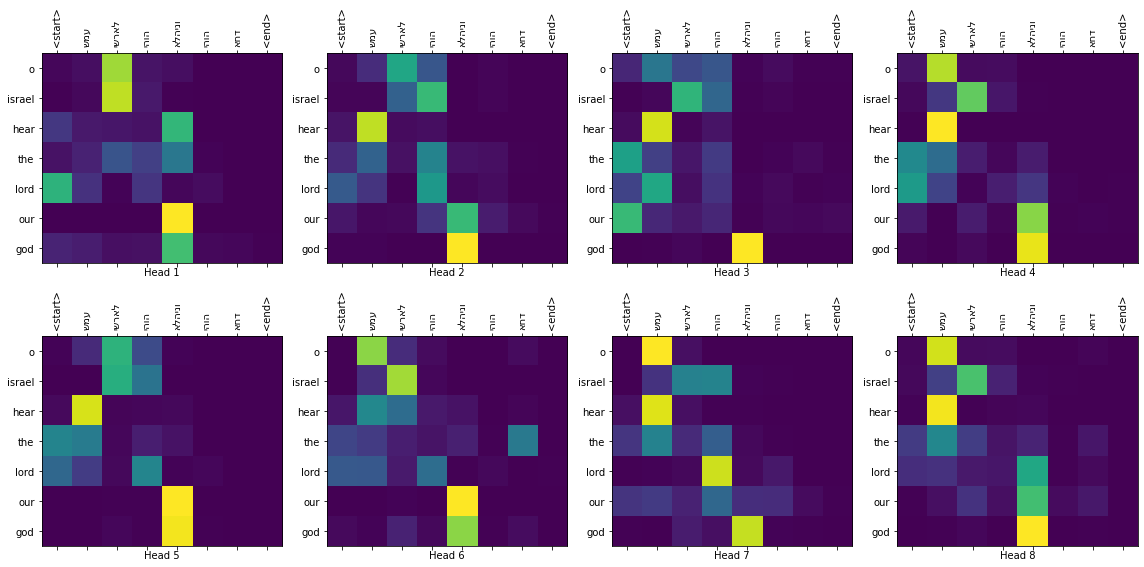

In [6]:
torahVerse = 'Deuteronomy.6.4'
showEngVerses(torahVerse)

hebrewVerse = 'שמע ישראל יהוה אלהינו יהוה אחד'
translate(hebrewVerse, plot='decoder_layer3_block2')


Jewish English Torah
-------------------------------------
nan

Metsudah Chumash, Metsudah Publications, 2009
-------------------------------------
you are to love adonoy your god with all your heart with all your soul and with all your possessions

Modernized Tanakh - Based on JPS 1917, Edited by Adam Cohn
-------------------------------------
nan

Tanakh: The Holy Scriptures, published by JPS
-------------------------------------
you shall love the lord your god with all your heart and with all your soul and with all your might

The Holy Scriptures: A New Translation (JPS 1917)
-------------------------------------
and thou shalt love the lord thy god with all thy heart and with all thy soul and with all thy might

The Koren Jerusalem Bible
-------------------------------------
and thou shalt love the lord thy god with all thy heart and with all thy soul and with all thy might

The Rashi chumash by Rabbi Shraga Silverstein
-------------------------------------
and you shall love the

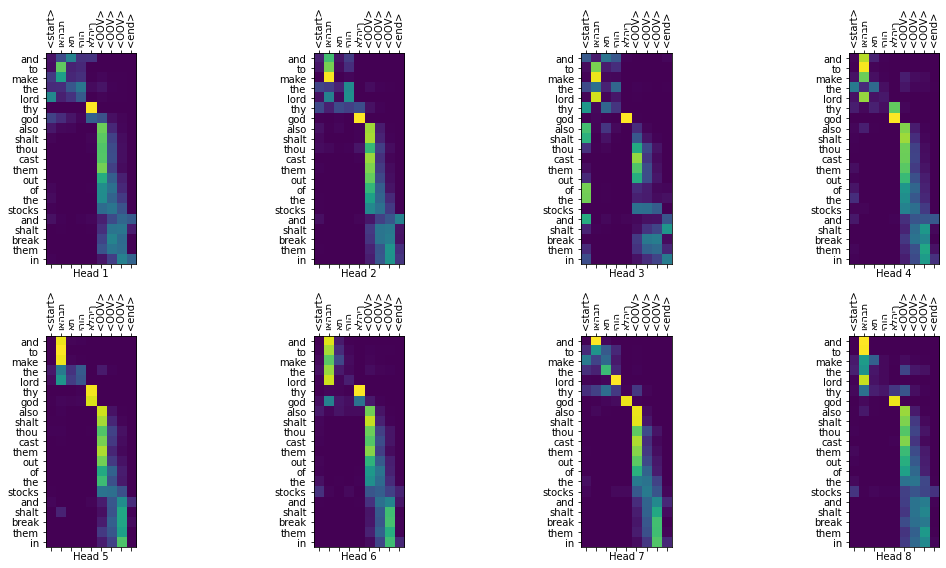

In [7]:
torahVerse = 'Deuteronomy.6.5'
showEngVerses(torahVerse)

hebrewVerse = 'ואהבת את יהוה אלהיך בכל־לבבך ובכל־נפשך ובכל־מאדך'
translate(hebrewVerse, plot='decoder_layer3_block2')


Jewish English Torah
-------------------------------------
nan

Metsudah Chumash, Metsudah Publications, 2009
-------------------------------------
and these words that i command you today shall be upon your heart

Modernized Tanakh - Based on JPS 1917, Edited by Adam Cohn
-------------------------------------
nan

Tanakh: The Holy Scriptures, published by JPS
-------------------------------------
take to heart these instructions with which i charge you this day

The Holy Scriptures: A New Translation (JPS 1917)
-------------------------------------
and these words which i command thee this day shall be upon thy heart

The Koren Jerusalem Bible
-------------------------------------
and these words which i command thee this day shall be in thy heart

The Rashi chumash by Rabbi Shraga Silverstein
-------------------------------------
and you shall love etc what is this love and these things that i command you this day they should be like a new edict to you shall be upon your heart for y

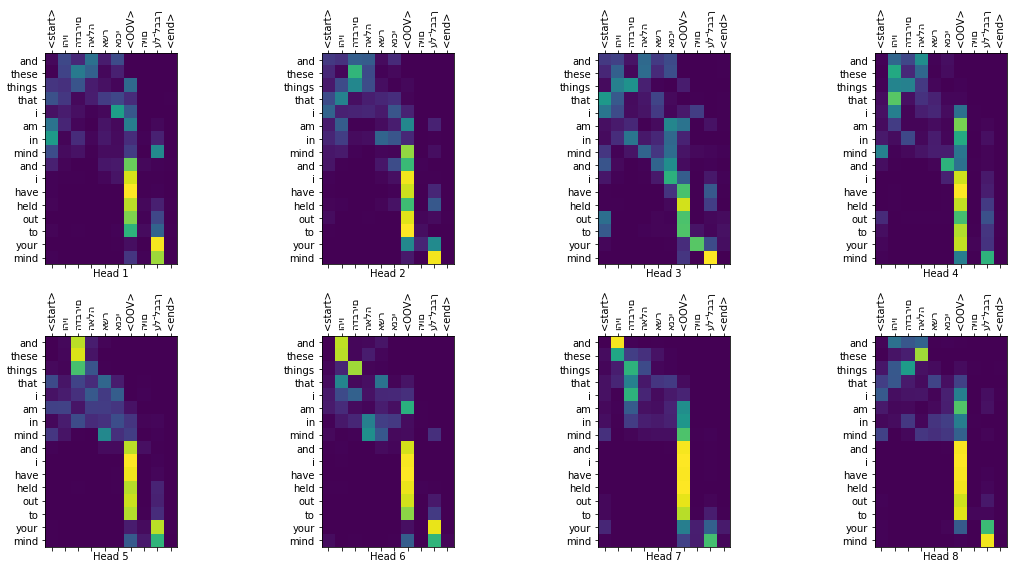

In [8]:
torahVerse = 'Deuteronomy.6.6'
showEngVerses(torahVerse)

hebrewVerse = 'והיו הדברים האלה אשר אנכי מצוך היום על־לבבך'
translate(hebrewVerse, plot='decoder_layer3_block2')


Jewish English Torah
-------------------------------------
nan

Metsudah Chumash, Metsudah Publications, 2009
-------------------------------------
that you will do us no harm just as we did not touch you we did nothing but good to you and sent you away in peace you are now the blessed one of adonoy

Modernized Tanakh - Based on JPS 1917, Edited by Adam Cohn
-------------------------------------
that you will do us no harm as we have not touched you and as we have done to you nothing but good and have sent you away in peace you are now the blessed of the lord

Tanakh: The Holy Scriptures, published by JPS
-------------------------------------
that you will not do us harm just as we have not molested you but have always dealt kindly with you and sent you away in peace from now on be you blessed of the lord

The Holy Scriptures: A New Translation (JPS 1917)
-------------------------------------
that thou wilt do us no hurt as we have not touched thee and as we have done unto thee nothin

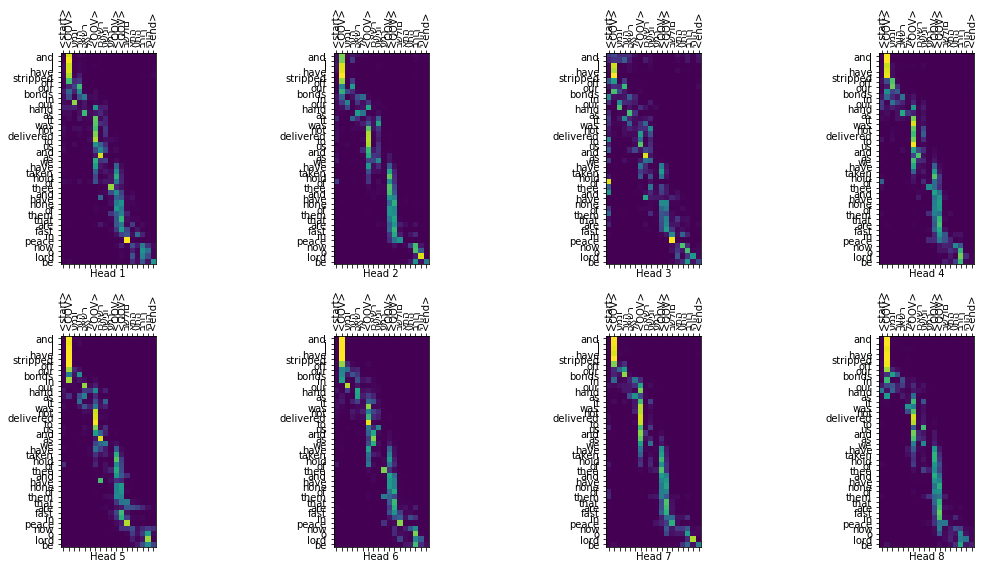



ML Translation
-------------------------------------
None




In [13]:
torahVerse = getRandoVerse()
showEngVerses(torahVerse)
showHebVerse(torahVerse)
showMLTrans(torahVerse)


Jewish English Torah
-------------------------------------
nan

Metsudah Chumash, Metsudah Publications, 2009
-------------------------------------
he god then said i am the god of your father the god of avraham the god of yitzchok and the god of yaakov moshe hid his face for he was afraid to look at elohim

Modernized Tanakh - Based on JPS 1917, Edited by Adam Cohn
-------------------------------------
nan

Tanakh: The Holy Scriptures, published by JPS
-------------------------------------
i am he said the god of your father the god of abraham the god of isaac and the god of jacob and moses hid his face for he was afraid to look at god

The Holy Scriptures: A New Translation (JPS 1917)
-------------------------------------
moreover he said i am the god of thy father the god of abraham the god of isaac and the god of jacob and moses hid his face for he was afraid to look upon god

The Koren Jerusalem Bible
-------------------------------------
moreover he said i am the god of thy fath

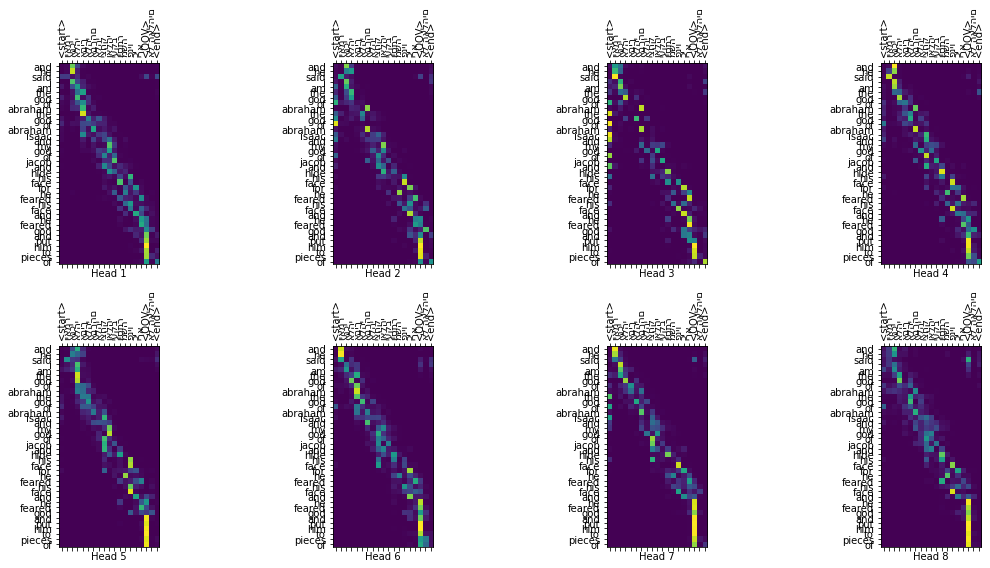



ML Translation
-------------------------------------
None




In [14]:
torahVerse = 'Exodus.3.6'

showEngVerses(torahVerse)
showHebVerse(torahVerse)
showMLTrans(torahVerse)